In [69]:
! python -V

Python 3.12.4


In [70]:
import math
import time
import random
import numpy as np
import json
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from bessel_zeros import get_bessel_zeros
from scipy.special import jv, jvp, gamma, loggamma
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
import matplotlib.ticker as ticker
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

from bessel_zeros import get_bessel_zeros
from CDFs3_working import build_cdfs as build_cdfs
import seaborn as sns

In [82]:
# ── PARAMETERS ──────────────────────────────────────────────────────────────
T_total = 10.0
DIM     = 5
S       = 1.0  # cylinder nondimensional step
N_ZEROS = 10
INV_R   = 2000
INV_T   = 2000
K       = 1.1
s       = 1.0
N_PATHS = 50_000
tol     = 1e-8
_eps    = np.finfo(np.float64).eps
nu  = DIM/2.0 - 1.0

In [72]:
# 1) Bessel zeros
print("Computing Bessel function zeros…")
zeros = get_bessel_zeros(DIM, N_ZEROS)
print(f" Retrieved {len(zeros)} zeros for ν={DIM/2 -1}")

Computing Bessel function zeros…
 Retrieved 10 zeros for ν=0.0


In [73]:
r_star, cdf_r, p_surv0, t_star, raw_t = build_cdfs(DIM, S, zeros, INV_R, INV_T)
p_surv0 = float(np.clip(p_surv0, 0.0, 1.0))
p_exit0 = 1.0 - p_surv0
print(f"  Survival Probability p_surv0 = {p_surv0:.6e}, Exit Probability p_exit0 = {p_exit0:.6e}")

# 3) Precompute inverse-CDF lookup tables (ensure monotone)
u_r = np.linspace(0.0, 1.0, INV_R)
cdf_r = np.maximum.accumulate(np.clip(cdf_r, 0.0, 1.0))
r_star_inv = np.interp(u_r, cdf_r, r_star)

  Survival Probability p_surv0 = 8.888972e-02, Exit Probability p_exit0 = 9.111103e-01


In [74]:
# 3) Precompute inverse-CDF lookup tables (ensure monotone)
u_r = np.linspace(0.0, 1.0, INV_R)
cdf_r = np.maximum.accumulate(np.clip(cdf_r, 0.0, 1.0))
r_star_inv = np.interp(u_r, cdf_r, r_star)

u_t = np.linspace(0.0, 1.0, INV_T)
if p_exit0 > 0.0:
    cond_exit_cdf = np.maximum.accumulate(np.clip(raw_t / p_exit0, 0.0, 1.0))
    t_star_inv = np.interp(u_t, cond_exit_cdf, t_star)
else:
    t_star_inv = np.zeros_like(u_t)

In [75]:
def simulate_whole_path(T_rem: float) -> np.ndarray:
    center = np.full(DIM, s, dtype=np.float64)
    t_0 = 0
    path = np.insert(center, 0, t_0)[None,:]
    while True:
        if T_rem <= tol:
            return path

        # R so that t* = T_rem/R^2 = S
        R = math.sqrt(max(T_rem, 0.0) / S)

        # Random direction on unit sphere
        direction = np.random.normal(size=DIM)
        nrm = np.linalg.norm(direction)
        if nrm <= _eps:
            direction = np.zeros(DIM); direction[0] = 1.0
        else:
            direction /= nrm

        # Degenerate guards first
        if p_surv0 <= 0.0:
            u_e = np.random.rand()
            idx = min(int(u_e * (INV_T - 1)), INV_T - 1)
            t_s = t_star_inv[idx]
            tau = t_s * T_rem
            center += R * direction
            T_rem  -= tau
            t_0 += tau
            path = np.concatenate((path,np.insert(center,0,t_0)[None,:]), axis = 0)
            continue

        if p_surv0 >= 1.0 - 1e-15:
            u_c = np.random.rand()
            idx = min(int(u_c * (INV_R - 1)), INV_R - 1)
            r_s = r_star_inv[idx]
            center += (r_s * R) * direction
            path = np.concatenate((path,np.insert(center,0,t_0+T_rem)[None,:]), axis = 0)
            return path

        # Standard branch
        u = np.random.rand()
        if u < p_surv0:
            u_c = u / p_surv0
            idx = min(int(u_c * (INV_R - 1)), INV_R - 1)
            r_s = r_star_inv[idx]
            center += (r_s * R) * direction
            path = np.concatenate((path,np.insert(center,0,t_0+T_rem)[None,:]), axis = 0)
            return path
        else:
            u_e = (u - p_surv0) / p_exit0
            idx = min(int(u_e * (INV_T - 1)), INV_T - 1)
            t_s = t_star_inv[idx]
            tau = t_s * T_rem
            center += R * direction
            T_rem  -= tau
            t_0 += tau
            path = np.concatenate((path,np.insert(center,0,t_0)[None,:]), axis = 0)

In [76]:
sample_paths = []
for i in range(N_PATHS):
    if i and (i % 50_000 == 0):
        print(f"Simulated {i} paths…")
    sample_paths.append(simulate_whole_path(T_total))

In [77]:
sum = 0
for s in sample_paths:
    sum += s.shape[0]
sum/N_PATHS
    

11.97654

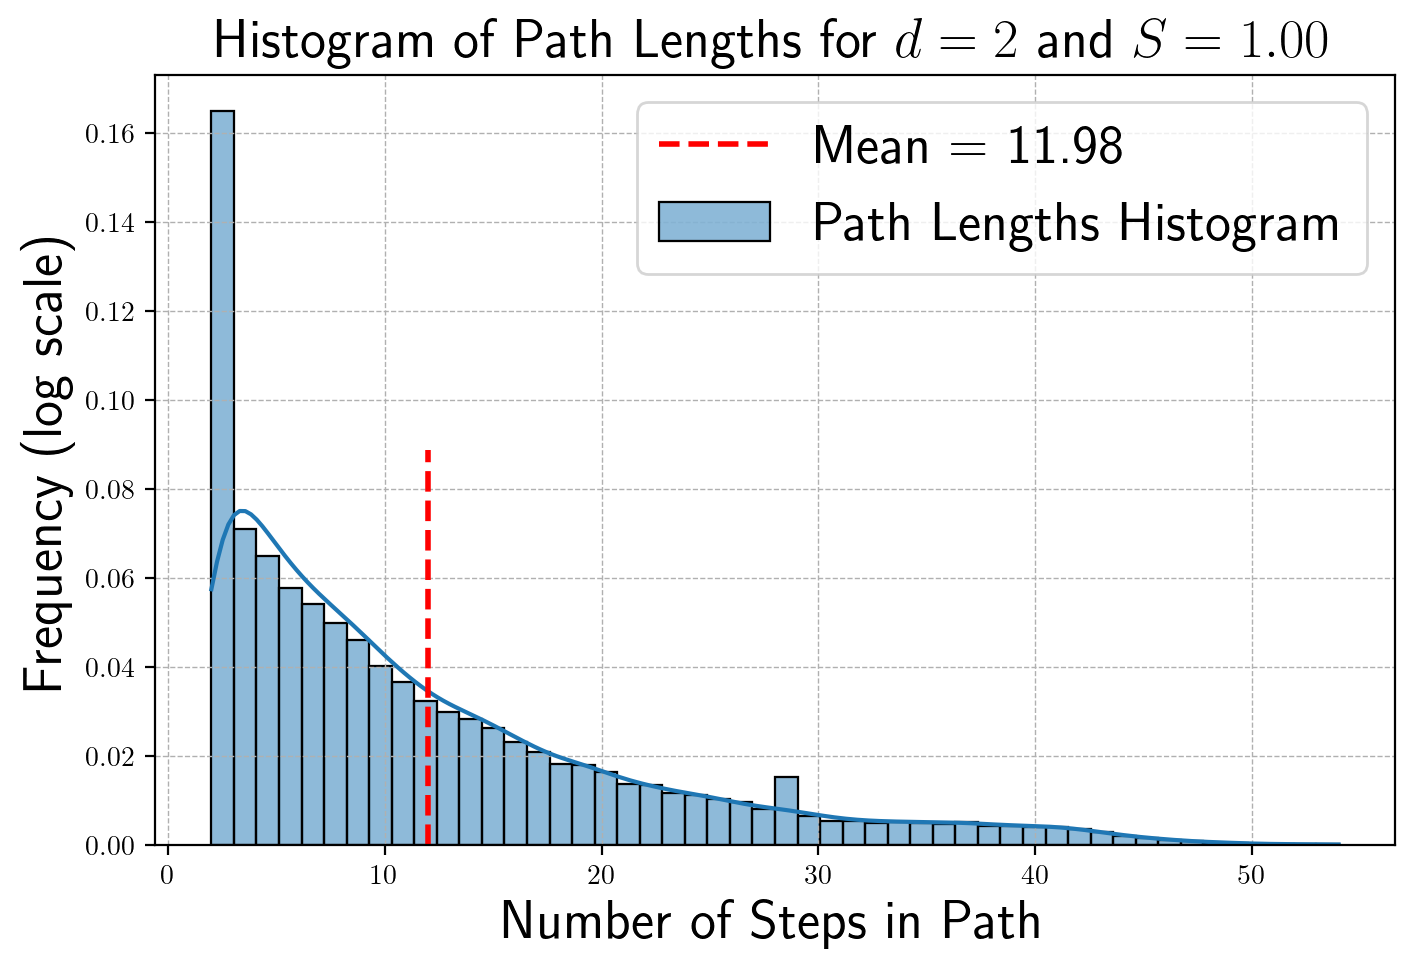

In [78]:
length = []
for s in sample_paths:
    length.append(s.shape[0])
length = np.array(length)
_, counts = np.unique(length, return_counts=True)
# Find the maximum frequency
highest_density = counts.max()/length.size
f = plt.figure(figsize=(8, 5),dpi=200)
sns.histplot(x=length, kde=True, bins=50,label='Path Lengths Histogram',stat= 'density')
# plt.yscale('log')
plt.vlines(np.mean(length),0,highest_density, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {np.mean(length):.2f}')
plt.xlabel('Number of Steps in Path', fontproperties=font)
plt.ylabel('Frequency (log scale)', fontproperties=font)
plt.title(f'Histogram of Path Lengths for $d={DIM}$ and $S={S:.2f}$', fontproperties=font)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(prop=font)
plt.show()
f.savefig(f'{DIM}_{S:.2f}.pdf',format="pdf",dpi=600);

In [ ]:
# open a json file to save path lengths
d = 10
with open(f"path_length_{d}.json", 'r') as json_file:
        # Use json.load() to convert the file content into a Python dictionary
        length_dict = json.load(json_file)


In [119]:
avg_length = np.array([[s, np.mean(length)] for s, length in length_dict.items()])
avg_length = avg_length.astype(float)
np.round(avg_length,3,out=None)

array([[  0.2  ,   2.414],
       [  0.4  ,   4.592],
       [  0.6  ,  10.449],
       [  0.8  ,  21.959],
       [  1.   ,  37.205],
       [  1.2  ,  53.06 ],
       [  1.4  ,  68.153],
       [  1.6  ,  82.551],
       [  1.8  ,  96.216],
       [  2.   , 109.394]])

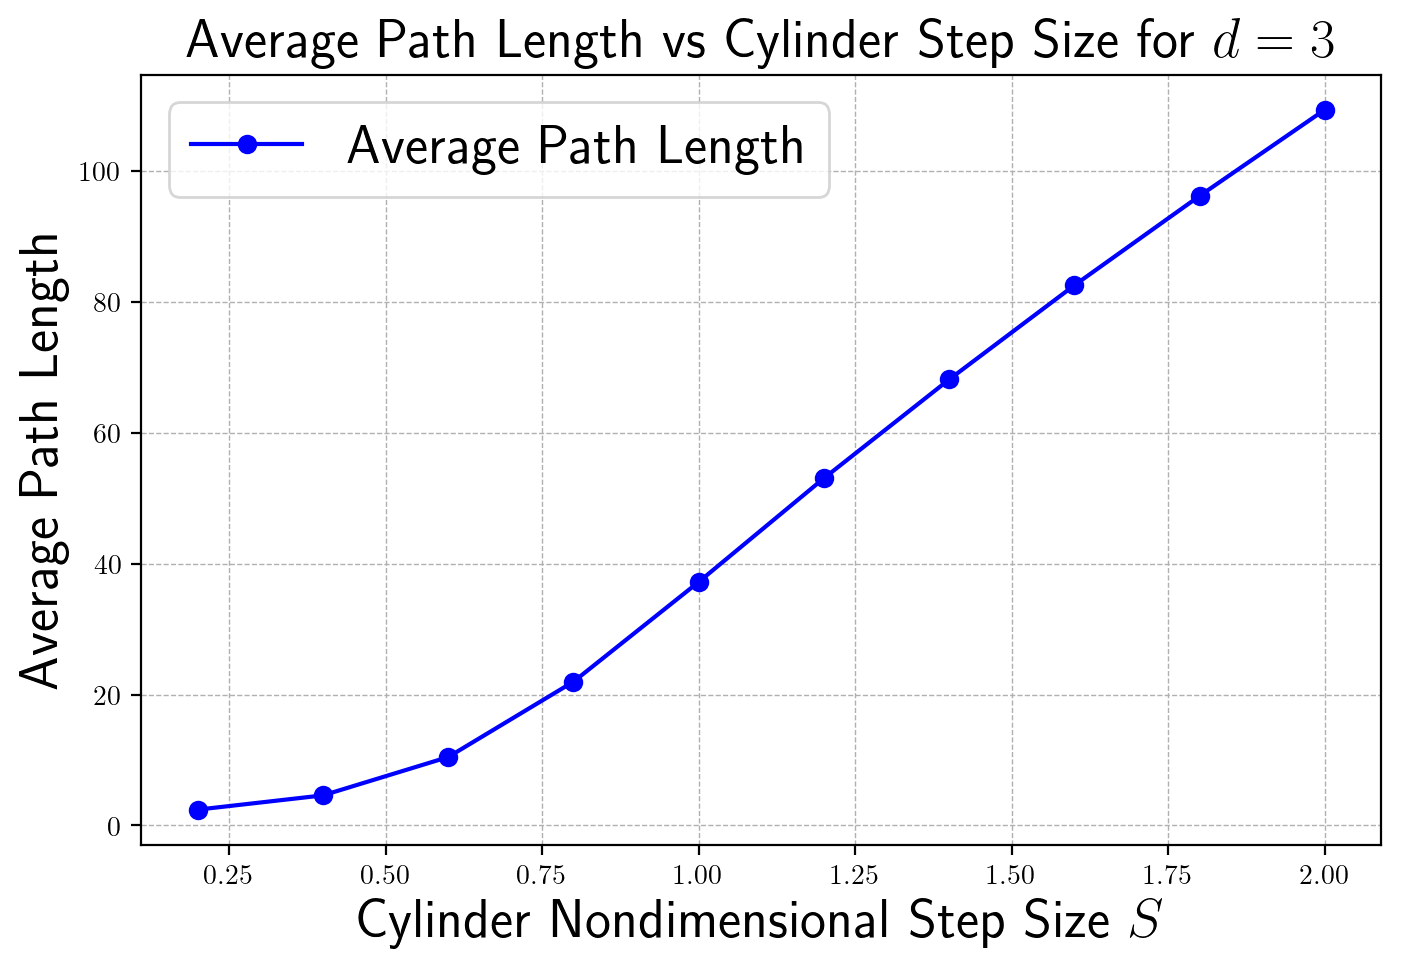

In [ ]:
# ── PLOTTING ────────────────────────────────────────────────────────────────
f , ax = plt.subplots(figsize=(8, 5),dpi=200)
ax.plot(avg_length[:,0], avg_length[:,1], marker='o', linestyle='-', color='blue', label='Average Path Length')
plt.xlabel('Cylinder Nondimensional Step Size $S$', fontproperties=font)
plt.ylabel('Average Path Length', fontproperties=font)
plt.title(f'Average Path Length vs Cylinder Step Size for $d={d}$', fontproperties=font)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(prop=font)
plt.show()
f.savefig(f'avg_path_length_{d}.pdf',format="pdf",dpi=600)

In [122]:
#finding the slopes
(avg_length[1:,1] - avg_length[:-1,1]) / (avg_length[1:,0] - avg_length[:-1,0])

array([10.8928, 29.283 , 57.5484, 76.2325, 79.2731, 75.4673, 71.9911,
       68.3211, 65.8899])